# Langgraph Agents

In [3]:
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_groq import ChatGroq
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langgraph.graph import StateGraph, END, START
from langchain_core.pydantic_v1 import BaseModel, Field
import getpass
from prompt_poet import Prompt
from langchain_core.pydantic_v1 import create_model

In [4]:
groq_api_key = getpass.getpass()

In [5]:
class State(BaseModel):
    resume: str
    job_description: str
    extracted_skills_resume: list[str] = Field(default_factory=list)
    extracted_skills_job_description: list[str] = Field(default_factory=list)
    skills_match: list[str] = Field(default_factory=list)
    company_fit: str = ""
    role_fit: str = ""
    final_answer: str = ""

In [6]:
def get_skill_extraction_job_description(state: State) -> State:
    SkillsOutput = create_model("SkillsOutput", extracted_skills_job_description=(list[str], ...))
    raw_template = """
    - name: system instructions
      role: system
      content: |
       Extract the skills from the resume and job description.
    - name: user query
      role: user
      content: |
       {{ escape_special_characters(text) }}
    """
    llm_job_extraction = ChatGroq(temperature=0, model_name="llama3-groq-70b-8192-tool-use-preview",
                              api_key=groq_api_key).with_structured_output(SkillsOutput)
    template_data = {
    "text": state.job_description
    }
    prompt = Prompt(
    raw_template=raw_template,
    template_data=template_data
    )
    result = llm_job_extraction.invoke(prompt.messages)
    state.extracted_skills_job_description = result.extracted_skills_job_description
    return state

In [7]:
def get_skill_extraction_resume(state: State) -> State:
    SkillsOutput = create_model("SkillsOutput", extracted_skills_resume=(list[str], ...))
    raw_template = """
    - name: system instructions
      role: system
      content: |
       Extract the skills from the resume and job description.
    - name: user query
      role: user
      content: |
       {{ escape_special_characters(text) }}
    """
    llm_job_extraction = ChatGroq(temperature=0, model_name="llama3-groq-70b-8192-tool-use-preview",
                              api_key=groq_api_key).with_structured_output(SkillsOutput)
    template_data = {
    "text": state.resume
    }
    prompt = Prompt(
    raw_template=raw_template,
    template_data=template_data
    )
    result = llm_job_extraction.invoke(prompt.messages)
    state.extracted_skills_resume = result.extracted_skills_resume
    return state

In [8]:
def get_semantic_matcher(state: State) -> State:
    SkillsMatch = create_model("SkillsOutput", skills_match=(list[str], ...))
    raw_template = """
    - name: system instructions
      role: system
      content: |
       You are an expert in matching skills between the resume and job description.
    - name: user query
      role: user
      content: |
       Job description SKills: {{ escape_special_characters(text1) }}
       Resume Skills: {{ escape_special_characters(text2) }}
    """
    llm_job_extraction = ChatGroq(temperature=0, model_name="llama3-groq-70b-8192-tool-use-preview",
                              api_key=groq_api_key).with_structured_output(SkillsMatch)
    template_data = {
    "text1": ','.join(state.extracted_skills_job_description),
    "text2": ','.join(state.extracted_skills_resume)
    }
    prompt = Prompt(
    raw_template=raw_template,
    template_data=template_data
    )
    result = llm_job_extraction.invoke(prompt.messages)
    state.skills_match = result.skills_match
    return state

In [9]:
def get_company_fit(state: State) -> State:
    raw_template = """
    - name: system instructions
      role: system
      content: |
       You are trying to determine if the company is a good fit for the user. 
       If the job desctiption mentions a company that is a product based company, but the resume does not contain companies that are product based, then it is a bad fit.
       If the job desctiption mentions a company that is a service based company, but the resume does not contain companies that are service based, then it is not a good fit.
    - name: user query
      role: user
      content: |
       Answer with yes or no. Provide an explantion for your answer.
       Job Description: {{ escape_special_characters(text) }}
       Resume: {{ escape_special_characters(text2) }}
    """
    llm_job_extraction = ChatGroq(temperature=0, model_name="llama3-groq-70b-8192-tool-use-preview",
                              api_key=groq_api_key)
    template_data = {
    "text": state.job_description,
    "text2": state.resume
    }
    prompt = Prompt(
    raw_template=raw_template,
    template_data=template_data
    )
    result = llm_job_extraction.invoke(prompt.messages)
    state.company_fit = result.content
    return state

In [10]:
def get_role_fit(state: State) -> State:
    raw_template = """
    - name: system instructions
      role: system
      content: |
       You are trying to determine if the role is a good fit for the user. 
       If the role is asking for skills that are not in the resume, then it is not a good fit.
       If the role is asking for a manager role, but the resume does not contain any manager roles, then it is not a good fit.
    - name: user query
      role: user
      content: |
       Answer with yes or no. Provide an explantion for your answer.
       Job Description: {{ escape_special_characters(text) }}
       Resume: {{ escape_special_characters(text2) }}
    """
    llm_job_extraction = ChatGroq(temperature=0, model_name="llama3-groq-70b-8192-tool-use-preview",
                              api_key=groq_api_key)
    template_data = {
    "text": state.job_description,
    "text2": state.resume
    }
    prompt = Prompt(
    raw_template=raw_template,
    template_data=template_data)
    result = llm_job_extraction.invoke(prompt.messages)
    state.role_fit = result.content
    return state

In [11]:
import json
def get_final_answer(state: State) -> State:
    print(state)
    raw_template = """
    - name: system instructions
      role: system
      content: |
       You have to give the final answer based on the job description and resume.
       You have access to the following variables:
       {{ escape_special_characters(state) }}
       Please make a most probable answer based on the above information. Please summarize your findings
    """ 
    llm_job_extraction = ChatGroq(temperature=0, model_name="llama3-groq-70b-8192-tool-use-preview",
                              api_key=groq_api_key)
    template_data = {
    "state": json.dumps(dict(state))
    }
    prompt = Prompt(
    raw_template=raw_template,
    template_data=template_data)
    result = llm_job_extraction.invoke(prompt.messages)
    state.final_answer = result.content
    return state

In [12]:
workflow = StateGraph(State)

workflow.add_node("skill_extraction_job_description_node", get_skill_extraction_job_description)
workflow.add_node("skill_extraction_resume_node", get_skill_extraction_resume)
# parallel nodes
workflow.add_node("semantic_matcher_node", get_semantic_matcher)
workflow.add_node("company_fit_node", get_company_fit)
workflow.add_node("role_fit_node", get_role_fit)
workflow.add_node("final_answer_node", get_final_answer)

# adding edges
workflow.add_edge(START, "skill_extraction_job_description_node")
workflow.add_edge("skill_extraction_job_description_node", "skill_extraction_resume_node")


workflow.add_edge("skill_extraction_resume_node", "semantic_matcher_node")
workflow.add_edge("semantic_matcher_node", "company_fit_node")
workflow.add_edge("company_fit_node", "role_fit_node")


workflow.add_edge("role_fit_node", "final_answer_node")

workflow.add_edge("final_answer_node", END)
workflow.set_entry_point("skill_extraction_job_description_node")


In [13]:
graph = workflow.compile()

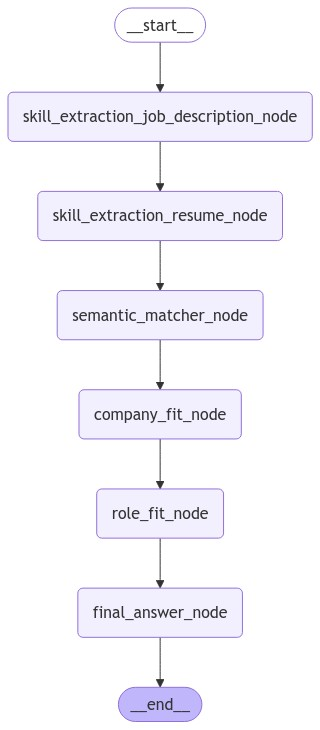

In [14]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
from unicodedata import normalize
def norm_text(input_text):
    return normalize('NFKD', input_text).encode('ascii','ignore').decode('ascii')

In [16]:
import re

def remove_unicode_special_chars(text):
    # Use regex to remove any character that is not alphanumeric or space
    return re.sub(r'[^\w\s]', '', text)


In [17]:
resume = '''
Sandeep Tammu
Senior Data Scientist
H 9396499409
T 8328080336
B sandeeptammu42@gmail.com
m https://github.com/Sandeep42
Education
2013-2015 Master of Science, Physics (8.17/10) (Indian Institute of Science Education and Research)
2009 - 2013 B.Tech. Electronics and Communications Engineering (Nagarjuna University)
Career Summary
A highly skilled Senior Data Scientist with over 8 years of experience in designing and deploying advanced machine
learning models and AI-driven solutions across diverse industries.
Key expertise in NLP (few-shot models, RAG, LLM finetuning, Prompt Engineering), improving CTR, buiding ETA
prediction models.
Proficient in handling MLOps initiatives, implementing scalable architectures and pipelines on multiple cloud platforms
(AWS, GCP, Azure)
Core Skills
• Machine Learning, Deep Learning
• Python
• Numpy, Scipy, Pandas
• Jupyter Notebook, scikit learn,
PyTorch
• Elasticsearch
• Natural language processing
• AWS by , GCP, Azure
• SQL, Git
• Probabilty and Statistics
August 2022 -
Aug 2024
Senior Data Scientist
Equinix - Nityo Infotech
Role outline
Lead development of ML solutions focusing on NLP, predictive analytics, and MLOps. Design and implement
scalable AI-driven systems across cloud platforms to drive business growth and operational efficiency.
Achievements
Identifying Relevant Opportunities in the US Public Sector
• Identified key sales opportunities for Equinix across the US Public Sector, analyzing approximately 100,000
upcoming opportunities from 20+ departments and 2.5 million historical contracts using a model built with
SetFit(BERT), achieving over 90% accuracy.
• Fine tuned BERT models on the corpus to generate domain specific embedding model. Used the embedding
model to create topics using BERTopic.
• Collaborated with the sales team for data labeling, employed few-shot learning, and performed model calibration
to enhance confidence scores.
• Successfully implemented an end-to-end solution in Google Cloud using Vertex AI pipelines with Kubeflow
components that analyze and update sales opportunities weekly.
Building Self Serve RAG Platform
• Self-Serve RAG is a platform enabling users to create a RAG based on their dataset and other configurable
parameters. Built the platform top of Azure Cloud Services (Event hub, Functions, CosmosDB) and stream
processing, it is scalable and ensures consistent performance with larger datasets and queries.
• Used llamaindex to chunk documents, create vector stores, re-rank the documents and augment the LLM with
retrieved documents.
• Enabled developers to have the option to choose a given stack, compare their choices with other configurations
and deploy a separate endpoint for their QA with docs or chat with retrieved documents.
Customer Health Score
• Developed a proactive approach to identify customer health and reduce churn. By analyzing 30+ key metrics
such as product usage, customer feedback, and support usage.
• The built system provides an explainable quantitative score representing the health of each customer across
different product segments, proactively identifying potential churn and improve customer health.
• Used Aspect based sentiment analysis, identified aspects and their sentiments from NPS reviews, identified key
issues and themes contributing to negative reviews.
MLOps and Deployment Handling
• Data Visualization and User Feedback: Deployed 14+ Streamlit dashboards across various initiatives,
including 4 for capturing user feedback on model performance.
• Implemented robust packaging and containerization for all the dashboards using Docker to ensure reliable deployment and scalability.
• Developed a Streamlit dashboard to gather feedback on generative AI initiatives, summarize support tickets,
and provide recommendations for next steps.
• API Development: Created 4 FastAPI live endpoints with comprehensive data validation, logging, and monitoring capabilities. Performed load testing to ensure consistent performance. Integrated one of the API into
Salesforce on live data.
February 2019 -
August 2022
Senior Data Scientist
Blackbuck
Role outline
Developed and deployed ML models for logistics optimization, user behavior prediction, and personalization.
Focused on improving operational efficiency and enhancing user experience through data-driven solutions.
Achievements
• Truck ETA Prediction Model: Developed and deployed a model that accurately predicts the estimated time
of arrival (ETA) of trucks at unloading points. This model improved operational efficiency by making trucks
available even before unloading, resulting in at least a 10% increase in liquidity.
• Trip Stoppage Classification: Leveraged historical transactional data to train a Gradient Boosted Regression
Trees model, classifying truck stoppages into "Trip Node" and "Non-Trip Node." Enhanced the accuracy of trip
generation logic from 54% to 84%, improving insights into historical user movements and enhancing customer
experience in the application.
• Click-Through Rate (CTR) Improvement: Estimated user click probabilities using historical data and
deployed the model with MLflow and AWS Sagemaker. This implementation resulted in a 2% improvement in
CTR.
• Word2Vec Model for Attribute Similarity: Built a Word2Vec model using session data from user activity,
effectively capturing similarities between various attributes to provide more personalized user experiences.
August 2016-
February 2019
Senior Data Scientist
AVR Edge Networks
Role outline
Developed and deployed advanced NLP and search solutions for the HR tech industry. Focused on enhancing information retrieval, document parsing, and classification models to improve recruitment processes and user experiences.
Achievements
• Enterprise Search Solution with Elasticsearch: Deployed an enterprise search solution leveraging Elasticsearch, extensively customizing scoring through Groovy scripting. Innovatively utilized the parent-child relationship (nested queries) to retrieve relevant resumes and implemented a decay algorithm to reduce scores for
irrelevant profiles, significantly improving search quality by 7% as validated by user search log analysis.
• Resume Parser: Developed and deployed a resume parser that automatically identifies key sections such as
education, work experience, and personal information. Trained a Long Short-Term Memory (LSTM) model,
achieving over 90% accuracy in classifying individual resume sentences across all sections.
• Job Title Classification Model: Deployed a multi-class classification model trained on job descriptions to
predict job titles. The model’s performance was evaluated using Precision@5, achieving a score of 75 on the
validation set.
• Made contributions to open-source projects in deep learning and gained experience coding and training models
in PyTorch. Additionally, contributed to the Edge Networks technical blog with articles on machine learning
and deep learning topics.
'''

In [28]:
job_description = '''
This opportunity is with one of our Client which is a fast-paced software company that partners with innovative B2B and B2C SaaS companies for their digital transformation needs.

Location : Bengaluru (Hybrid - 3 days from Office/week)

Experience: 6 - 10 years

The Opportunity

As a Data Scientist II, you will be part of the Product Risk Operations team that owns the development of AI-powered technology that helps our clients make communities safer and more resilient. Our technology helps our customers in reducing carbon emissions, reducing infrastructure risk and avoiding fatalities, a fact that we pride ourselves in.

As a part of the Risk Operations team, you will be working on a wide range of activities related to end-to-end Machine Learning (ML) deployments, research and development of ML product features to support internal and external stakeholders. This is a great role for someone who enjoys variety and is also looking to expand their skill set in a structured fashion.

Who You Are

 5-8 years of experience building and deploying machine learning models.
 Master's or PHD in statistics, mathematics, computer science or another quantitative field.
 Strong problem solving skills with emphasis on product development.
 Well versed in programming languages such as R or Python with experience using libraries such as pandas, scikit-learn, tensor flow .
 Experience with SQL and relational databases for data extraction and manipulation.
 Experience using a variety of Machine Learning techniques for Predictive Modeling,
 Classification, Natural Language Processing (including Large Language Models),
 Content Recommendation Systems, Time Series Techniques.
 Passionate about being up-to-date with the latest developments in Machine Learning.
 Strong organizational, time management, and communication skills.
 High degree of accountability.
 Utility, Infrastructure or Energy related field experience is a plus.

Benefits/Culture

 Comprehensive Insurance (Life, Health, Accident)
 Flexible Work Model
 Accelerated learning & non-linear growth
 Flat organisation structure driven by ownership and accountability.
 Global Peers - Working with some of the best engineers/professionals globally from the likes of Apple,
 Amazon, IBM Research, Adobe and other innovative product companies
 Ability to make a global impact with your work, leading innovations in Conversational AI, Tele-Medicine, Healthcare and more.
 You will work with a founding team of serial entrepreneurs with multiple successful exits to their credit. The learning will be immense just as will the challenges.

(ref:hirist.tech)

'''

In [29]:
resume = remove_unicode_special_chars(resume)
job_description = remove_unicode_special_chars(job_description)

In [30]:
person = State.parse_obj({
    "resume": resume,
    "job_description": job_description,
    "extracted_skills_resume": [],
    "extracted_skills_job_description": [],
    "skills_match": [],
    "company_fit": "",
    "role_fit": "",
    "final_answer": ""
})

In [31]:
result = graph.invoke(person)

In [27]:
result

'Based on the analysis, the candidate is not a good fit for the Data Scientist position at SatSure due to a lack of experience in the agriculture infrastructure and climate action sectors. Additionally, the role is not a good fit for the candidate as they lack experience in computer vision and deep learning.'